<a href="https://colab.research.google.com/github/upadhyan/Tarkington-Conversational-Analysis/blob/main/TarkICProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing and Data Engineering
### Loading Packages

In [ ]:
!pip install flair
!pip install autocorrect

In [ ]:
%cd /content/drive/My\ Drive/University\ Residences/TarkIC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import flair
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
sentiment_model = flair.models.TextClassifier.load('en-sentiment')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import os
from datetime import datetime
import string
from tqdm.notebook import tqdm
from autocorrect import Speller
import math
import wordcloud


/content/drive/My Drive/University Residences/TarkIC
2021-08-19 20:40:26,979 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [ ]:
df = pd.read_csv('IC.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna()
df.head()

,Initiating user,Date entered,First Name:,Last Name:,Convo,Follow-Up? Yes/No,Tags,RACount,TotalCount
0,RA5,"March 10, 2021, 04:44 PM",A,0,i did a wellness check on a. he mentioned he s...,Yes,"Campus/Community Involvement, Goal Setting/Car...",1,1
1,RA1,"March 22, 2021, 08:55 PM",B,1,we discussed classes and plans for the summer.,No,"Academics, Goal Setting/Career Planning",1,2
2,RA1,"March 22, 2021, 08:57 PM",C,2,we talked about how classes are going and work...,No,Academics,2,3
3,RA8,"April 12, 2021, 08:04 PM",D,3,we talked about class and how he dealt with pe...,No,"Academics, Campus/Community Involvement, Frien...",1,4
4,RA7,"April 12, 2021, 08:05 PM",E,4,e and i talked about where he is going to live...,No,"Campus/Community Involvement, Mental Health",1,5


Since we are using flair, we don't need to remove stopwords. In fact, removing stopwords may mess up the analysis because words like "but" and "didn't" are considered stopwords, but flair is trained to handle negation. However, trimming stopwords is useful for creating a wordcloud, which is something we want to do. We will also use `autocorrect` however to make sure typos don't affect our analysis.

In [ ]:
spell = Speller()
df['corrected_convo'] = df['Convo'].apply(lambda x: spell(x))

In [ ]:
def clean_convo(convo):
  lemmatizer = WordNetLemmatizer()
  spell = Speller()
  convo = spell(convo)
  stop_words = list(stopwords.words('english'))
  custom_stop_words = ['talk', 'talked','discuss', 'discussed',
                       'about', 'ask', 'asked', 'mention', 'tell', 'told',
                       'mentioned', 'chat', 'said', 'wa']
  full_stop_words = stop_words + custom_stop_words
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  tokenized = tokenizer.tokenize(convo)
  result = []
  for w in tokenized:
    d = lemmatizer.lemmatize(w)
    if d not in full_stop_words:
      result.append(d)
  return ' '.join(result)
#clean_convo('talk talked discussed')
df['trimmed_convo'] = df['corrected_convo'].apply(clean_convo)

We are also going to create new columns based on the Tags column to make it easier to filter and search for tags

In [ ]:
def tag_columns(convo):
  return 'Academics' in convo,'Campus/Community Involvement' in convo,'Friends/Family/Relationships' in convo,'Goal Setting/Career Planning' in convo,'Finances' in convo,'Mental Health' in convo,'Social Justice' in convo
df['Academics'], df['CampusCommunityInvolvement'], df['FriendsFamilyRelationships'], df['GoalSettingCareerPlanning'],df['Finances'],df['MentalHealth'],df['SocialJustice'] = zip(*df['Tags'].map(tag_columns))

In [ ]:
df.head()

,Initiating user,Date entered,First Name:,Last Name:,Convo,Follow-Up? Yes/No,Tags,RACount,TotalCount,corrected_convo,trimmed_convo,Academics,CampusCommunityInvolvement,FriendsFamilyRelationships,GoalSettingCareerPlanning,Finances,MentalHealth,SocialJustice
0,RA5,"March 10, 2021, 04:44 PM",A,0,i did a wellness check on a. he mentioned he s...,Yes,"Campus/Community Involvement, Goal Setting/Car...",1,1,i did a wellness check on a. he mentioned he s...,wellness check signed anxiety workshop checkin...,False,True,False,True,False,True,False
1,RA1,"March 22, 2021, 08:55 PM",B,1,we discussed classes and plans for the summer.,No,"Academics, Goal Setting/Career Planning",1,2,we discussed classes and plans for the summer.,class plan summer,True,False,False,True,False,False,False
2,RA1,"March 22, 2021, 08:57 PM",C,2,we talked about how classes are going and work...,No,Academics,2,3,we talked about how classes are going and work...,class going working asynchronous class,True,False,False,False,False,False,False
3,RA8,"April 12, 2021, 08:04 PM",D,3,we talked about class and how he dealt with pe...,No,"Academics, Campus/Community Involvement, Frien...",1,4,we talked about class and how he dealt with pe...,class dealt personal issue plan summer,True,True,True,False,False,True,False
4,RA7,"April 12, 2021, 08:05 PM",E,4,e and i talked about where he is going to live...,No,"Campus/Community Involvement, Mental Health",1,5,e and i talked about where he is going to live...,e going live next year rushed frac going livin...,False,True,False,False,False,True,False


## Sentiment Analysis
Lets apply Flair to all of our conversations and get the label and confidence for each one. 

In [ ]:
def perform_analysis(convo):
  flair_sentence = flair.data.Sentence(convo)
  sentiment_model.predict(flair_sentence)
  value = flair_sentence.labels[0].value
  confidence = flair_sentence.labels[0].score
  if value == 'POSITIVE':
    score = confidence
  else: 
    score = 1 - confidence
  return [flair_sentence.labels[0].value, flair_sentence.labels[0].score, score]

In [ ]:
df['value'], df['confidence'], df['happiness_score'] = zip(*df['corrected_convo'].map(perform_analysis))

In [ ]:
df.head()

,Initiating user,Date entered,First Name:,Last Name:,Convo,Follow-Up? Yes/No,Tags,RACount,TotalCount,corrected_convo,trimmed_convo,Academics,CampusCommunityInvolvement,FriendsFamilyRelationships,GoalSettingCareerPlanning,Finances,MentalHealth,SocialJustice,value,confidence,happiness_score
0,RA5,"March 10, 2021, 04:44 PM",A,0,i did a wellness check on a. he mentioned he s...,Yes,"Campus/Community Involvement, Goal Setting/Car...",1,1,i did a wellness check on a. he mentioned he s...,wellness check signed anxiety workshop checkin...,False,True,False,True,False,True,False,NEGATIVE,0.947207,0.052793
1,RA1,"March 22, 2021, 08:55 PM",B,1,we discussed classes and plans for the summer.,No,"Academics, Goal Setting/Career Planning",1,2,we discussed classes and plans for the summer.,class plan summer,True,False,False,True,False,False,False,POSITIVE,0.931686,0.931686
2,RA1,"March 22, 2021, 08:57 PM",C,2,we talked about how classes are going and work...,No,Academics,2,3,we talked about how classes are going and work...,class going working asynchronous class,True,False,False,False,False,False,False,POSITIVE,0.997021,0.997021
3,RA8,"April 12, 2021, 08:04 PM",D,3,we talked about class and how he dealt with pe...,No,"Academics, Campus/Community Involvement, Frien...",1,4,we talked about class and how he dealt with pe...,class dealt personal issue plan summer,True,True,True,False,False,True,False,POSITIVE,0.966296,0.966296
4,RA7,"April 12, 2021, 08:05 PM",E,4,e and i talked about where he is going to live...,No,"Campus/Community Involvement, Mental Health",1,5,e and i talked about where he is going to live...,e going live next year rushed frac going livin...,False,True,False,False,False,True,False,POSITIVE,0.923050,0.923050


## Post Processing

In [ ]:
tags = ['Academics', 'CampusCommunityInvolvement', 'FriendsFamilyRelationships', 'GoalSettingCareerPlanning','Finances', 'MentalHealth' ,'SocialJustice']
tag_frames =[]
tag_info= []
for tag in tags:
  frame = df[df[tag]]
  mean = frame['happiness_score'].mean()
  if math.isnan(mean):
    mean = 0
  average_confidence = frame['confidence'].mean()
  if math.isnan(average_confidence):
    average_confidence = 0
  else:
    average_confidence = (average_confidence - .5) * 2 
  tag_info_dict = {
      'tag':tag,
      'tag_count':len(frame),
      'pos_count':len(frame[frame['value'] == 'POSITIVE']),
      'neg_count':len(frame[frame['value'] == 'NEGATIVE']),
      'quality_score': average_confidence,
      'average_score': mean,
      'keywords': ' '.join(frame['trimmed_convo'])
  }
  tag_frames.append(frame)
  tag_info.append(tag_info_dict)
tag_result = pd.DataFrame(tag_info)
tag_result = tag_result[tag_result['tag_count'] > 0]
tag_result

,tag,tag_count,pos_count,neg_count,quality_score,average_score,keywords
0,Academics,75,64,11,0.757717,0.768365,class plan summer class going working asynchro...
1,CampusCommunityInvolvement,48,44,4,0.763526,0.808911,wellness check signed anxiety workshop checkin...
2,FriendsFamilyRelationships,31,28,3,0.734289,0.815824,class dealt personal issue plan summer plan su...
3,GoalSettingCareerPlanning,29,21,8,0.636612,0.610701,wellness check signed anxiety workshop checkin...
4,Finances,7,3,4,0.527585,0.413048,job campus help pay college stock market findi...
5,MentalHealth,13,10,3,0.901913,0.728701,wellness check signed anxiety workshop checkin...


In [ ]:
ras = df['Initiating user'].unique()
ras_frame = []
ras_info = []
for ra in ras:
  frame = df[df['Initiating user'] == ra]
  mean = frame['happiness_score'].mean()
  variance = frame['happiness_score'].var()
  if (math.isnan(variance)):
    variance = 0
  if math.isnan(mean):
    mean = 0
  average_confidence = frame['confidence'].mean()
  if math.isnan(average_confidence):
    average_confidence = 0
  else:
    average_confidence = (average_confidence - .5) * 2
  ra_info_dict = {
      'RA':ra,
      'ra_count':len(frame),
      'pos_count':len(frame[frame['value'] == 'POSITIVE']),
      'neg_count':len(frame[frame['value'] == 'NEGATIVE']),
      'average_score': mean,
      'quality_score':average_confidence,
      'variance':variance,
      'keywords': ' '.join(frame['trimmed_convo'])
  }
  ras_frame.append(frame)
  ras_info.append(ra_info_dict)
ras_result = pd.DataFrame(ras_info)
ras_result

,RA,ra_count,pos_count,neg_count,average_score,quality_score,variance,keywords
0,RA5,33,20,13,0.627842,0.872337,0.190686,wellness check signed anxiety workshop checkin...
1,RA1,34,26,8,0.682501,0.693746,0.110194,class plan summer class going working asynchro...
2,RA8,2,2,0,0.977356,0.954712,0.000245,class dealt personal issue plan summer plan su...
3,RA7,4,4,0,0.879152,0.758304,0.020015,e going live next year rushed frac going livin...
4,RA6,1,1,0,0.923327,0.846655,0.000000,mechanical engineering home
5,RA4,9,8,1,0.904718,0.902752,0.053799,j current class well weekend class going ok on...
6,RA2,27,22,5,0.776300,0.884253,0.129827,class upcoming test planning taking exam overa...
7,RA3,10,10,0,0.711269,0.422539,0.000000,class final summer plan future semester plan h...


### Exporting data

In [ ]:
tag_result.to_csv('topic_breakdown.csv', index=False)
df.to_csv('processedICs.csv',index = False)
ras_result.to_csv('floor_breakdown.csv', index = False)
words = pd.Series(' '.join(df['trimmed_convo']).split())
words.to_csv('word_mentions.csv', index = False)

## Visualizations
### Word Cloud

In [ ]:
wordcloud.WordCloud(background_color = "white",font_path='visualizations/Montserrat-Regular.ttf').generate(' '.join(df['trimmed_convo'])).to_file('visualizations/total_wordmap.png')
for index, row in ras_result.iterrows():
  if not row['keywords'] == '':
    file_specifier = ''.join(row['RA'].split())
    wordcloud.WordCloud(background_color = "white",font_path='visualizations/Montserrat-Regular.ttf').generate(row['keywords']).to_file('visualizations/floors/' + file_specifier + '_wordcloud.png')
for index, row in tag_result.iterrows():
  if not row['keywords'] == '':
    file_specifier = ''.join(row['tag'].split()).replace("/","")
    wordcloud.WordCloud(background_color = "white",font_path='visualizations/Montserrat-Regular.ttf').generate(row['keywords']).to_file('visualizations/topics/' + file_specifier + '_wordcloud.png')

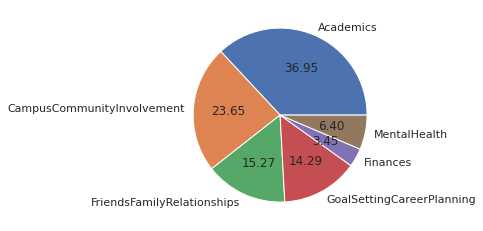

In [ ]:
plt.pie(tag_result['tag_count'], labels=tag_result['tag'], autopct='%.2f');